$$

\begin{cases}

dS_t = \mu(c-\ln(S_t))S_t dt + \sigma_1 S_t dW^1_t\\

dH_t = \mu(c-H_t)dt + \sigma_2 dW^2_t\\

dV_t = a(X^2_t + bH_t + cV_t)dt + \sigma_3 dW^3_t\\

dX_t = V_t dt

\end{cases}

$$

la funzione obiettivo (la soluzione della PDE) è

$$

u(t,s,h,v,x) = e^{-t}(s + sh + v^2 + xv)

$$

e la BSDE è un po' convoluta:

$$

dY_t = -(Y_t - e^{-t}( (1-H_t)\mu(c-\ln(S_t))S_t + \mu(c-H_t)S_t + (2V_t+X_t)a(X_t^2+bH_t+cV_t) +V_t^2 +\sigma_3^2 ))dt + Z_t dW_t

$$

In [1]:
# NN 
import numpy as np
import tensorflow.compat.v1 as tf 
tf.disable_v2_behavior()
import time
from abc import ABC, abstractmethod

class FBSNN(ABC):
    def __init__(self, Xi, T, M, N, D, layers):
        self.Xi = Xi
        self.T = T
        self.M = M
        self.N = N
        self.D = D
        self.layers = layers
        self.weights, self.biases = self.initialize_NN(layers)
        self.sess = tf.Session(config = tf.ConfigProto(allow_soft_placement = True, log_device_placement = True))
        self.learning_rate = tf.placeholder(tf.float32, shape = [])
        self.t_tf = tf.placeholder(tf.float32, shape = [M, N+1, 1])
        self.W_tf = tf.placeholder(tf.float32, shape = [M, N+1, D])
        self.Xi_tf = tf.placeholder(tf.float32, shape = [1, D])
        self.loss, self.X_pred, self.Y_pred, self.Y0_pred = self.loss_function(self.t_tf, self.W_tf, self.Xi_tf)
        self.optimizer = tf.train.AdamOptimizer(learning_rate = self.learning_rate)
        self.train_op = self.optimizer.minimize(self.loss)
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0, num_layers-1):
            W = self.xavier_init(size = [layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1, layers[l+1]], dtype = tf.float32))
            weights.append(W)
            biases.append(b)
        return weights, biases
    
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev = xavier_stddev), dtype = tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        H = X
        for l in range(0, num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.sin(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
    
    def net_u(self, t, X):
        u = self.neural_net(tf.concat([t, X], axis = 1), self.weights, self.biases)
        Du = tf.gradients(u, X)[0]
        return u, Du
    
    def Dg_tf(self, X):
        return tf.gradients(self.g_tf(X), X)[0]
    
    def loss_function(self, t, W, Xi):
        loss = 0
        X_list = []
        Y_list = []
        
        t0 = t[:,0,:]
        W0 = W[:,0,:]
        X0 = tf.tile(Xi, [self.M, 1])

        Y0, Z0 = self.net_u(t0, X0)

        X_list.append(X0)
        Y_list.append(Y0)

        for n in range(0, self.N):
            t1 = t[:, n+1, :]
            W1 = W[:, n+1, :]
            X1 = X0 + self.mu_tf(t0, X0, Y0, Z0) * (t1 - t0) + tf.squeeze(tf.matmul(self.sigma_tf(t0, X0, Y0), tf.expand_dims(W1 - W0, -1)), axis = [-1])
            Y1_tilde = Y0 + self.phi_tf(t0, X0, Y0, Z0) * (t1 - t0) + tf.reduce_sum(Z0 * tf.squeeze(tf.matmul(self.sigma_tf(t0, X0, Y0), tf.expand_dims(W1 - W0, -1))), axis = 1, keepdims = True)
            Y1, Z1 = self.net_u(t1, X1)

            loss += tf.reduce_sum(tf.square(Y1 - Y1_tilde))

            t0 = t1
            W0 = W1
            X0 = X1
            Y0 = Y1
            Z0 = Z1

            X_list.append(X1)
            Y_list.append(Y1)

        loss += tf.reduce_sum(tf.square(Y1 - self.g_tf(X1)))
        loss += tf.reduce_sum(tf.square(Z1 - self.Dg_tf(X1)))

        X = tf.stack(X_list, axis = 1)
        Y = tf.stack(Y_list, axis = 1)

        return loss, X, Y, Y[0,0,0]

    def fetch_minibatch(self):
        T = self.T
        M = self.M
        N = self.N
        D = self.D
        
        Dt = np.zeros((M, N+1, 1))
        DW = np.zeros((M, N+1, D))

        dt = T / N
        Dt[:, 1:, :] = dt
        DW[:, 1:, :] = np.sqrt(dt) * np.random.normal(size=(M, N, D))

        t = np.cumsum(Dt, axis = 1)
        W = np.cumsum(DW, axis = 1)

        return t, W

    def train(self, epochs, learning_rate):
        start_time = time.time()
        for epoch in range(epochs):
            t_batch, W_batch = self.fetch_minibatch()
            tf_dict = {self.Xi_tf: self.Xi, self.t_tf: t_batch, self.W_tf: W_batch, self.learning_rate: learning_rate}
            self.sess.run(self.train_op, tf_dict)

            if epoch % 10 == 0:
                elapsed = time.time() - start_time
                loss_value, Y0_value, learning_rate = self.sess.run([self.loss, self.Y0_pred, self.learning_rate], tf_dict)
                print('Epoch: %d, Loss: %.3e, Y0: %.3f, Time: %.2f' % (epoch, loss_value, Y0_value, elapsed))
                start_time = time.time()
    
    def predict(self, Xi_star, t_star, W_star):
        tf_dict = {self.Xi_tf: Xi_star, self.t_tf: t_star, self.W_tf: W_star}
        X_star = self.sess.run(self.X_pred, tf_dict)
        Y_star = self.sess.run(self.Y_pred, tf_dict)
        return X_star, Y_star
    
    @abstractmethod
    def g_tf(self, X):
        pass

    @abstractmethod
    def phi_tf(self, t, X, Y, Z):
        pass

    @abstractmethod
    def mu_tf(self, t, X, Y, Z):
        M = self.M
        D = self.D
        return tf.zeros([M, D])

    @abstractmethod
    def sigma_tf(self, t, X, Y):
        M = self.M
        D = self.D
        return tf.matrix_diag(tf.ones([M, D]))

Instructions for updating:
non-resource variables are not supported in the long term


Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0

========Avvio del training========
Epoch: 0, Loss: 1.802e+04, Y0: 0.855, Time: 6.72
Epoch: 10, Loss: 8.307e+03, Y0: 7.084, Time: 0.64
Epoch: 20, Loss: 3.260e+03, Y0: 0.550, Time: 0.63
Epoch: 30, Loss: 1.808e+03, Y0: 2.469, Time: 0.63
Epoch: 40, Loss: 3.189e+03, Y0: 2.910, Time: 0.63
Epoch: 50, Loss: 1.112e+03, Y0: 3.917, Time: 0.63
Epoch: 60, Loss: 7.243e+02, Y0: 3.864, Time: 0.63
Epoch: 70, Loss: 9.222e+02, Y0: 4.241, Time: 0.63
Epoch: 80, Loss: 5.102e+02, Y0: 3.769, Time: 0.64
Epoch: 90, Loss: 1.899e+02, Y0: 3.210, Time: 0.63
Epoch: 100, Loss: 3.320e+02, Y0: 3.256, Time: 0.64
Epoch: 110, Loss: 1.329e+03, Y0: 2.811, Time: 0.62
Epoch: 120, Loss: 1.466e+02, Y0: 2.638, Time: 0.62
Epoch: 130, Loss: 3.919e+02, Y0: 2.584, Time: 0.63
Epoch: 140, Loss: 1.673e+02, Y0: 2.798, Time: 0.62
Epoch: 150, Loss: 6.425e+01, Y0: 2.601, Time: 0.63
Epoch

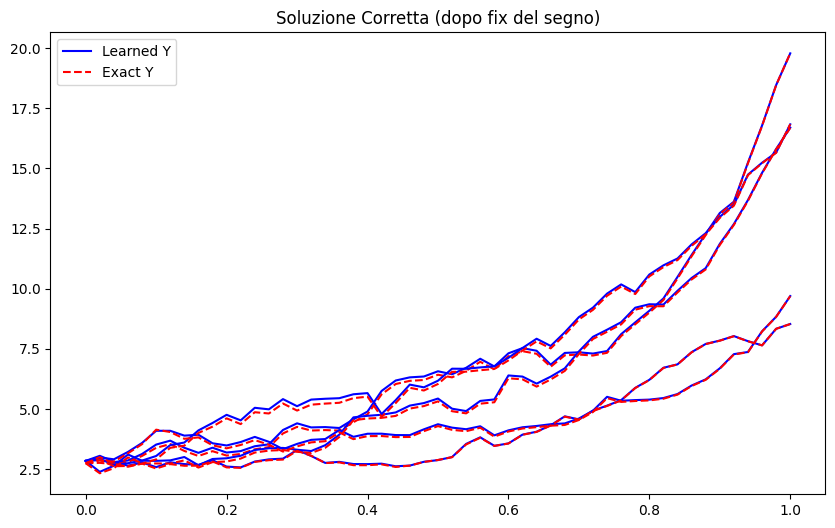

In [2]:
# implementazione classe NNImplemented
class NNImplemented(FBSNN):
    def __init__(self, Xi, T, M, N, D, layers, params):
        # Parametri definiti PRIMA di super().__init__
        self.mu = params['mu']
        self.a = params['a']
        self.b = params['b']
        self.c = params['c']
        self.sigma1 = params['sigma1']
        self.sigma2 = params['sigma2']
        self.sigma3 = params['sigma3']

        super().__init__(Xi, T, M, N, D, layers)

    def phi_tf(self, t, X, Y, Z):
        S, H, V, X_state = tf.split(X, num_or_size_splits=4, axis=1)
        
        # Casting parametri
        mu = tf.cast(self.mu, tf.float32)
        c  = tf.cast(self.c, tf.float32)
        a  = tf.cast(self.a, tf.float32)
        b  = tf.cast(self.b, tf.float32)
        s3 = tf.cast(self.sigma3, tf.float32)

        exp_t = tf.exp(-t)
        
        # Termini base
        term_S = mu * (c - tf.log(S)) * S
        term_H = mu * (c - H)
        term_V = a * (X_state**2 + b*H + c*V)

        # --- IL PUNTO CRITICO ---
        # Testo originale: (1.0 - H)
        # Matematica per u=S+SH: richiede (1.0 + H)
        # Se lasci (1.0 - H), la rete convergerà a una soluzione diversa da u_exact.
        part1 = (1.0 + H) * term_S 
        
        part2 = term_H * S
        part3 = (2.0*V + X_state) * term_V
        part4 = V**2 + s3**2

        equation = part1 + part2 + part3 + part4
        equation = tf.cast(equation, tf.float32)

        # Ricordati il segno meno globale davanti alla parentesi
        return -(Y - (exp_t * equation))
    
    def g_tf(self, X):
        S, H, V, X_state = tf.split(X, num_or_size_splits=4, axis=1)
        exp_T = tf.exp(-self.T)
        val = S + (S*H) + (V**2) + (X_state*V)
        return exp_T * val
    
    def mu_tf(self, t, X, Y, Z):
        S, H, V, X_state = tf.split(X, num_or_size_splits=4, axis=1)
        # Casting parametri
        mu = tf.cast(self.mu, tf.float32)
        c  = tf.cast(self.c, tf.float32)
        a  = tf.cast(self.a, tf.float32)
        b  = tf.cast(self.b, tf.float32)

        dS = mu * (c - tf.log(S)) * S
        dH = mu * (c - H)
        dV = a * (X_state**2 + b*H + c*V)
        dX = V
        return tf.concat([dS, dH, dV, dX], axis=1)

    def sigma_tf(self, t, X, Y):
        S, H, V, X_state = tf.split(X, num_or_size_splits=4, axis=1)
        
        # Casting parametri
        s1 = tf.cast(self.sigma1, tf.float32)
        s2 = tf.cast(self.sigma2, tf.float32)
        s3 = tf.cast(self.sigma3, tf.float32)

        zeros = tf.zeros_like(S)
        
        r1 = tf.concat([s1 * S, zeros, zeros, zeros], axis=1)
        r2 = tf.concat([zeros, s2 * tf.ones_like(H), zeros, zeros], axis=1)
        r3 = tf.concat([zeros, zeros, s3 * tf.ones_like(V), zeros], axis=1)
        r4 = tf.concat([zeros, zeros, zeros, zeros], axis=1)

        sigma_matrix = tf.stack([r1, r2, r3, r4], axis=1)
        return sigma_matrix


if __name__ == "__main__":
    import matplotlib.pyplot as plt

    M = 100
    N = 50
    D = 4
    T = 1.0

    params = {
        'mu': np.float32(1.0),
        'c': np.float32(1.0),
        'b': np.float32(1.0),
        'a': np.float32(1.0),
        'sigma1': np.float32(0.5),
        'sigma2': np.float32(0.5),
        'sigma3': np.float32(0.5),
    }

    # S0 = 1.5 per evitare problemi con log(0)
    Xi = np.array([1.5, 0.5, 0.5, 0.5]).reshape(1, D)
    
    layers = [D+1] + 4*[256] + [1]

    model = NNImplemented(Xi, T, M, N, D, layers, params)

    print('========Avvio del training========')
    # --- CORREZIONE TRAINING SCHEDULE ---
    # Evitiamo 1e-2 che fa esplodere i gradienti.
    # Aumentiamo le epoche per dare tempo alla rete di convergere.
    model.train(epochs=2000, learning_rate=1e-3)
    model.train(epochs=4000, learning_rate=1e-4) # Fase cruciale di stabilizzazione
    model.train(epochs=4000, learning_rate=1e-5) # Fine tuning
    model.train(epochs=4000, learning_rate=1e-6)
    
    # --- PLOTTING ---
    t_test, W_test = model.fetch_minibatch()
    X_pred, Y_pred = model.predict(Xi, t_test, W_test)
    
    def u_exact(t, Xi_arr):
        S = Xi_arr[:, 0:1]
        H = Xi_arr[:, 1:2]
        V = Xi_arr[:, 2:3]
        X = Xi_arr[:, 3:4]
        return np.exp(-t) * (S + S*H + V**2 + X*V)

    Xi_reshaped = X_pred.reshape(-1, D)
    t_reshaped = t_test.reshape(-1, 1)
    Y_exact = u_exact(t_reshaped, Xi_reshaped).reshape(M, N+1, 1)
    
    exact_Y0 = u_exact(np.array([[0.0]]), Xi)[0,0]
    print(f"\nPredicted Y0: {Y_pred[0,0,0]:.4f}")
    print(f"Exact Y0:     {exact_Y0:.4f}")
    
    plt.figure(figsize=(10,6))
    plt.plot(t_test[0,:,0], Y_pred[0,:,0], 'b', label='Learned Y')
    plt.plot(t_test[0,:,0], Y_exact[0,:,0], 'r--', label='Exact Y')
    plt.plot(t_test[1:5,:,0].T, Y_pred[1:5,:,0].T, 'b')
    plt.plot(t_test[1:5,:,0].T, Y_exact[1:5,:,0].T, 'r--')
    plt.title("Soluzione Corretta (dopo fix del segno)")
    plt.legend()
    plt.show()

In [7]:
# implementazione classe NNImplemented
class NNImplemented(FBSNN):
    def __init__(self, Xi, T, M, N, D, layers, params):
        # Parametri definiti PRIMA di super().__init__
        self.mu = params['mu']
        self.a = params['a']
        self.b = params['b']
        self.c = params['c']
        self.sigma1 = params['sigma1']
        self.sigma2 = params['sigma2']
        self.sigma3 = params['sigma3']

        super().__init__(Xi, T, M, N, D, layers)

    def phi_tf(self, t, X, Y, Z):
        S, H, V, X_state = tf.split(X, num_or_size_splits=4, axis=1)
        
        # Casting
        mu = tf.cast(self.mu, tf.float32)
        c  = tf.cast(self.c, tf.float32)
        a  = tf.cast(self.a, tf.float32)
        b  = tf.cast(self.b, tf.float32)
        s3 = tf.cast(self.sigma3, tf.float32)

        exp_t = tf.exp(-t)
        
        # --- FIX SICUREZZA 1: Logaritmo protetto ---
        # Evita NaN se S diventa <= 0 per errore numerico
        safe_S = tf.maximum(S, 1e-6) 
        log_S = tf.log(safe_S)

        # Drift components
        term_S = mu * (c - log_S) * safe_S
        term_H = mu * (c - H)
        term_V = a * (X_state**2 + b*H + c*V)

        # (1 + H) per la matematica corretta di u=S+SH
        part1 = (1.0 + H) * term_S 
        part2 = term_H * safe_S # Usa safe_S anche qui
        part3 = (2.0*V + X_state) * term_V
        part4 = V**2 + s3**2

        equation = part1 + part2 + part3 + part4
        equation = tf.cast(equation, tf.float32)

        return -(Y - (exp_t * equation))

    def mu_tf(self, t, X, Y, Z):
        S, H, V, X_state = tf.split(X, num_or_size_splits=4, axis=1)
        
        mu = tf.cast(self.mu, tf.float32)
        c  = tf.cast(self.c, tf.float32)
        a  = tf.cast(self.a, tf.float32)
        b  = tf.cast(self.b, tf.float32)
        
        # --- FIX SICUREZZA 1 anche qui ---
        safe_S = tf.maximum(S, 1e-6)
        log_S = tf.log(safe_S)

        dS = mu * (c - log_S) * safe_S
        dH = mu * (c - H)
        dV = a * (X_state**2 + b*H + c*V)
        dX = V
        return tf.concat([dS, dH, dV, dX], axis=1)
    
    def g_tf(self, X):
        S, H, V, X_state = tf.split(X, num_or_size_splits=4, axis=1)
        exp_T = tf.exp(-self.T)
        val = S + (S*H) + (V**2) + (X_state*V)
        return exp_T * val

    def sigma_tf(self, t, X, Y):
        S, H, V, X_state = tf.split(X, num_or_size_splits=4, axis=1)
        
        # Casting parametri
        s1 = tf.cast(self.sigma1, tf.float32)
        s2 = tf.cast(self.sigma2, tf.float32)
        s3 = tf.cast(self.sigma3, tf.float32)

        zeros = tf.zeros_like(S)
        
        r1 = tf.concat([s1 * S, zeros, zeros, zeros], axis=1)
        r2 = tf.concat([zeros, s2 * tf.ones_like(H), zeros, zeros], axis=1)
        r3 = tf.concat([zeros, zeros, s3 * tf.ones_like(V), zeros], axis=1)
        r4 = tf.concat([zeros, zeros, zeros, zeros], axis=1)

        sigma_matrix = tf.stack([r1, r2, r3, r4], axis=1)
        return sigma_matrix


if __name__ == "__main__":
    import matplotlib.pyplot as plt

    M = 100
    N = 200
    D = 4
    T = 1.0

    params = {
        'mu': np.float32(1.5),
        'c': np.float32(1.2),
        'b': np.float32(1.3),
        'a': np.float32(1.4),
        'sigma1': np.float32(0.5),
        'sigma2': np.float32(0.5),
        'sigma3': np.float32(0.5),
    }

    # S0 = 1.5 per evitare problemi con log(0)
    Xi = np.array([1.5, 0.5, 0.5, 0.5]).reshape(1, D)
    
    layers = [D+1] + 4*[256] + [1]

    model = NNImplemented(Xi, T, M, N, D, layers, params)

    print('========Avvio del training========')
    # --- CORREZIONE TRAINING SCHEDULE ---
    # Evitiamo 1e-2 che fa esplodere i gradienti.
    # Aumentiamo le epoche per dare tempo alla rete di convergere.
    model.train(epochs=2000, learning_rate=1e-3)
    model.train(epochs=4000, learning_rate=1e-4) # Fase cruciale di stabilizzazione
    model.train(epochs=4000, learning_rate=1e-5) # Fine tuning
    model.train(epochs=4000, learning_rate=1e-6)
    
    # --- PLOTTING ---
    t_test, W_test = model.fetch_minibatch()
    X_pred, Y_pred = model.predict(Xi, t_test, W_test)
    
    def u_exact(t, Xi_arr):
        S = Xi_arr[:, 0:1]
        H = Xi_arr[:, 1:2]
        V = Xi_arr[:, 2:3]
        X = Xi_arr[:, 3:4]
        return np.exp(-t) * (S + S*H + V**2 + X*V)

    Xi_reshaped = X_pred.reshape(-1, D)
    t_reshaped = t_test.reshape(-1, 1)
    Y_exact = u_exact(t_reshaped, Xi_reshaped).reshape(M, N+1, 1)
    
    exact_Y0 = u_exact(np.array([[0.0]]), Xi)[0,0]
    print(f"\nPredicted Y0: {Y_pred[0,0,0]:.4f}")
    print(f"Exact Y0:     {exact_Y0:.4f}")
    
    plt.figure(figsize=(10,6))
    plt.plot(t_test[0,:,0], Y_pred[0,:,0], 'b', label='Learned Y')
    plt.plot(t_test[0,:,0], Y_exact[0,:,0], 'r--', label='Exact Y')
    plt.plot(t_test[1:5,:,0].T, Y_pred[1:5,:,0].T, 'b')
    plt.plot(t_test[1:5,:,0].T, Y_exact[1:5,:,0].T, 'r--')
    plt.title("Soluzione Corretta (dopo fix del segno)")
    plt.legend()
    plt.show()

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0

========Avvio del training========
Epoch: 0, Loss: 1.468e+06, Y0: 0.658, Time: 28.22
Epoch: 10, Loss: 1.040e+06, Y0: 9.306, Time: 2.42
Epoch: 20, Loss: 9.233e+05, Y0: 14.612, Time: 2.41
Epoch: 30, Loss: 9.168e+05, Y0: 17.545, Time: 2.41
Epoch: 40, Loss: 7.933e+05, Y0: 19.768, Time: 2.42
Epoch: 50, Loss: 7.963e+05, Y0: 22.624, Time: 2.40
Epoch: 60, Loss: 6.498e+05, Y0: 25.617, Time: 2.43
Epoch: 70, Loss: 7.715e+05, Y0: 28.884, Time: 2.41
Epoch: 80, Loss: 7.226e+05, Y0: 32.037, Time: 2.40
Epoch: 90, Loss: 7.105e+05, Y0: 34.188, Time: 2.42
Epoch: 100, Loss: 5.984e+05, Y0: 35.795, Time: 2.39
Epoch: 110, Loss: 5.571e+05, Y0: 36.790, Time: 2.41
Epoch: 120, Loss: 7.578e+05, Y0: 37.189, Time: 2.39
Epoch: 130, Loss: 5.985e+05, Y0: 36.763, Time: 2.40
Epoch: 140, Loss: 6.123e+05, Y0: 35.894, Time: 2.40
Epoch: 150, Loss: 5.047e+05, Y0: 33.791, T

KeyboardInterrupt: 

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0

========Avvio del training High Precision========
Epoch: 0, Loss: 5.226e+04, Y0: 0.660, Time: 13.11
Epoch: 10, Loss: 1.907e+04, Y0: 6.557, Time: 1.24
Epoch: 20, Loss: 1.114e+04, Y0: -0.033, Time: 1.24
Epoch: 30, Loss: 6.579e+03, Y0: 1.105, Time: 1.23
Epoch: 40, Loss: 5.473e+03, Y0: 2.237, Time: 1.28
Epoch: 50, Loss: 3.748e+03, Y0: 3.129, Time: 1.24
Epoch: 60, Loss: 7.106e+03, Y0: 2.985, Time: 1.22
Epoch: 70, Loss: 2.956e+03, Y0: 3.430, Time: 1.23
Epoch: 80, Loss: 2.180e+03, Y0: 3.123, Time: 1.23
Epoch: 90, Loss: 2.250e+03, Y0: 2.729, Time: 1.23
Epoch: 100, Loss: 1.848e+03, Y0: 2.515, Time: 1.24
Epoch: 110, Loss: 2.705e+03, Y0: 2.396, Time: 1.24
Epoch: 120, Loss: 6.165e+02, Y0: 2.287, Time: 1.24
Epoch: 130, Loss: 1.499e+03, Y0: 2.183, Time: 1.25
Epoch: 140, Loss: 1.015e+03, Y0: 2.206, Time: 1.23
Epoch: 150, Loss: 1.045e+02, Y0: 2.369,

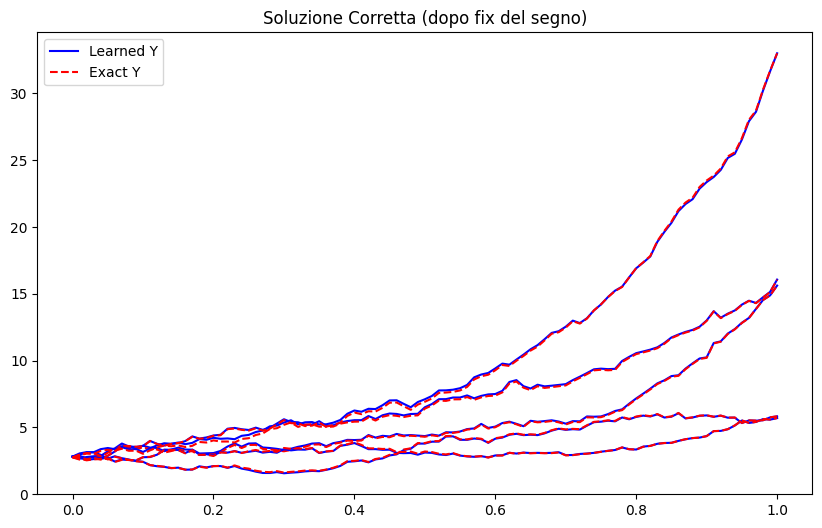

In [3]:
# implementazione classe NNImplemented
class NNImplemented(FBSNN):
    def __init__(self, Xi, T, M, N, D, layers, params):
        # Parametri definiti PRIMA di super().__init__
        self.mu = params['mu']
        self.a = params['a']
        self.b = params['b']
        self.c = params['c']
        self.sigma1 = params['sigma1']
        self.sigma2 = params['sigma2']
        self.sigma3 = params['sigma3']

        super().__init__(Xi, T, M, N, D, layers)

    def phi_tf(self, t, X, Y, Z):
        S, H, V, X_state = tf.split(X, num_or_size_splits=4, axis=1)
        
        # Casting
        mu = tf.cast(self.mu, tf.float32)
        c  = tf.cast(self.c, tf.float32)
        a  = tf.cast(self.a, tf.float32)
        b  = tf.cast(self.b, tf.float32)
        s3 = tf.cast(self.sigma3, tf.float32)

        exp_t = tf.exp(-t)
        
        # --- FIX SICUREZZA 1: Logaritmo protetto ---
        # Evita NaN se S diventa <= 0 per errore numerico
        safe_S = tf.maximum(S, 1e-6) 
        log_S = tf.log(safe_S)

        # Drift components
        term_S = mu * (c - log_S) * safe_S
        term_H = mu * (c - H)
        term_V = a * (X_state**2 + b*H + c*V)

        # (1 + H) per la matematica corretta di u=S+SH
        part1 = (1.0 + H) * term_S 
        part2 = term_H * safe_S # Usa safe_S anche qui
        part3 = (2.0*V + X_state) * term_V
        part4 = V**2 + s3**2

        equation = part1 + part2 + part3 + part4
        equation = tf.cast(equation, tf.float32)

        return -(Y - (exp_t * equation))

    def mu_tf(self, t, X, Y, Z):
        S, H, V, X_state = tf.split(X, num_or_size_splits=4, axis=1)
        
        mu = tf.cast(self.mu, tf.float32)
        c  = tf.cast(self.c, tf.float32)
        a  = tf.cast(self.a, tf.float32)
        b  = tf.cast(self.b, tf.float32)
        
        # --- FIX SICUREZZA 1 anche qui ---
        safe_S = tf.maximum(S, 1e-6)
        log_S = tf.log(safe_S)

        dS = mu * (c - log_S) * safe_S
        dH = mu * (c - H)
        dV = a * (X_state**2 + b*H + c*V)
        dX = V
        return tf.concat([dS, dH, dV, dX], axis=1)
    
    def g_tf(self, X):
        S, H, V, X_state = tf.split(X, num_or_size_splits=4, axis=1)
        exp_T = tf.exp(-self.T)
        val = S + (S*H) + (V**2) + (X_state*V)
        return exp_T * val

    def sigma_tf(self, t, X, Y):
        S, H, V, X_state = tf.split(X, num_or_size_splits=4, axis=1)
        
        # Casting parametri
        s1 = tf.cast(self.sigma1, tf.float32)
        s2 = tf.cast(self.sigma2, tf.float32)
        s3 = tf.cast(self.sigma3, tf.float32)

        zeros = tf.zeros_like(S)
        
        r1 = tf.concat([s1 * S, zeros, zeros, zeros], axis=1)
        r2 = tf.concat([zeros, s2 * tf.ones_like(H), zeros, zeros], axis=1)
        r3 = tf.concat([zeros, zeros, s3 * tf.ones_like(V), zeros], axis=1)
        r4 = tf.concat([zeros, zeros, zeros, zeros], axis=1)

        sigma_matrix = tf.stack([r1, r2, r3, r4], axis=1)
        return sigma_matrix

if __name__ == "__main__":
    import matplotlib.pyplot as plt

    # --- MODIFICA 1: Aumentiamo la precisione della simulazione ---
    M = 256      # Batch Size aumentato (era 100) -> Riduce il rumore del gradiente
    N = 100      # Step Temporali raddoppiati (era 50) -> Riduce l'errore di Eulero
    D = 4
    T = 1.0

    params = {
        'mu': np.float32(1.0),
        'c': np.float32(1.0),
        'b': np.float32(1.0),
        'a': np.float32(1.0),
        'sigma1': np.float32(0.5), # Volatilità basse aiutano
        'sigma2': np.float32(0.5),
        'sigma3': np.float32(0.5),
    }

    # Xi iniziale
    Xi = np.array([1.5, 0.5, 0.5, 0.5]).reshape(1, D)
    
    # Architettura (va bene così)
    layers = [D+1] + 4*[256] + [1]

    model = NNImplemented(Xi, T, M, N, D, layers, params)

    print('========Avvio del training High Precision========')
    
    # --- MODIFICA 2: Schedule più robusto ---
    # Fase di esplorazione veloce
    model.train(epochs=2000, learning_rate=1e-3)
    
    # Fase principale di convergenza (qui deve scendere sotto 1.0 di Loss)
    model.train(epochs=5000, learning_rate=1e-4) 
    
    # Fase di raffinamento (qui deve scendere sotto 0.1)
    model.train(epochs=5000, learning_rate=1e-5)
    
    # Fase finale di precisione
    model.train(epochs=5000, learning_rate=1e-6)
    
    # --- PLOTTING ---
    t_test, W_test = model.fetch_minibatch()
    X_pred, Y_pred = model.predict(Xi, t_test, W_test)
    
    def u_exact(t, Xi_arr):
        S = Xi_arr[:, 0:1]
        H = Xi_arr[:, 1:2]
        V = Xi_arr[:, 2:3]
        X = Xi_arr[:, 3:4]
        return np.exp(-t) * (S + S*H + V**2 + X*V)

    Xi_reshaped = X_pred.reshape(-1, D)
    t_reshaped = t_test.reshape(-1, 1)
    Y_exact = u_exact(t_reshaped, Xi_reshaped).reshape(M, N+1, 1)
    
    exact_Y0 = u_exact(np.array([[0.0]]), Xi)[0,0]
    print(f"\nPredicted Y0: {Y_pred[0,0,0]:.4f}")
    print(f"Exact Y0:     {exact_Y0:.4f}")
    
    plt.figure(figsize=(10,6))
    plt.plot(t_test[0,:,0], Y_pred[0,:,0], 'b', label='Learned Y')
    plt.plot(t_test[0,:,0], Y_exact[0,:,0], 'r--', label='Exact Y')
    plt.plot(t_test[1:5,:,0].T, Y_pred[1:5,:,0].T, 'b')
    plt.plot(t_test[1:5,:,0].T, Y_exact[1:5,:,0].T, 'r--')
    plt.title("Soluzione Corretta (dopo fix del segno)")
    plt.legend()
    plt.show()

In [4]:
if __name__ == "__main__":
    import matplotlib.pyplot as plt

    # Configurazioni standard
    M = 100
    N = 100
    D = 4
    T = 1.0

    # --- TEST SIGMA ZERO ---
    params = {
        'mu': np.float32(1.0),
        'c': np.float32(1.0),
        'b': np.float32(1.0),
        'a': np.float32(1.0),
        'sigma1': np.float32(0.0), # SPENTO
        'sigma2': np.float32(0.0), # SPENTO
        'sigma3': np.float32(0.0), # SPENTO
    }

    Xi = np.array([1.5, 0.5, 0.5, 0.5]).reshape(1, D)
    layers = [D+1] + 4*[256] + [1]

    model = NNImplemented(Xi, T, M, N, D, layers, params)

    print('======== DIAGNOSTICA: SIGMA ZERO ========')
    model.train(epochs=2000, learning_rate=1e-3) # Training veloce
    
    t_test, W_test = model.fetch_minibatch()
    X_pred, Y_pred = model.predict(Xi, t_test, W_test)
    
    # Soluzione esatta (vale anche con sigma=0)
    def u_exact(t, Xi_arr):
        S = Xi_arr[:, 0:1]
        H = Xi_arr[:, 1:2]
        V = Xi_arr[:, 2:3]
        X = Xi_arr[:, 3:4]
        return np.exp(-t) * (S + S*H + V**2 + X*V)

    Xi_reshaped = X_pred.reshape(-1, D)
    t_reshaped = t_test.reshape(-1, 1)
    Y_exact = u_exact(t_reshaped, Xi_reshaped).reshape(M, N+1, 1)
    
    exact_Y0 = u_exact(np.array([[0.0]]), Xi)[0,0]
    print(f"\nPredicted Y0: {Y_pred[0,0,0]:.4f}")
    print(f"Exact Y0:     {exact_Y0:.4f}")

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0

======== DIAGNOSTICA: SIGMA ZERO ========
Epoch: 0, Loss: 9.558e+03, Y0: 1.235, Time: 12.67
Epoch: 10, Loss: 2.182e+03, Y0: 11.563, Time: 1.24
Epoch: 20, Loss: 8.856e+02, Y0: 10.551, Time: 1.23
Epoch: 30, Loss: 2.566e+02, Y0: 10.274, Time: 1.24
Epoch: 40, Loss: 1.272e+02, Y0: 10.103, Time: 1.24
Epoch: 50, Loss: 6.312e+01, Y0: 9.595, Time: 1.23
Epoch: 60, Loss: 3.888e+01, Y0: 8.957, Time: 1.27
Epoch: 70, Loss: 2.495e+01, Y0: 8.176, Time: 1.24
Epoch: 80, Loss: 1.915e+01, Y0: 7.439, Time: 1.22
Epoch: 90, Loss: 1.583e+01, Y0: 6.765, Time: 1.22
Epoch: 100, Loss: 1.301e+01, Y0: 6.157, Time: 1.22
Epoch: 110, Loss: 1.132e+01, Y0: 5.657, Time: 1.23
Epoch: 120, Loss: 9.838e+00, Y0: 5.263, Time: 1.23
Epoch: 130, Loss: 8.667e+00, Y0: 4.936, Time: 1.22
Epoch: 140, Loss: 7.697e+00, Y0: 4.649, Time: 1.24
Epoch: 150, Loss: 6.889e+00, Y0: 4.398, Time

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0

========Avvio del training High Precision========
Epoch: 0, Loss: 1.783e+04, Y0: 0.702, Time: 46.12
Epoch: 10, Loss: 9.354e+03, Y0: 6.647, Time: 3.73
Epoch: 20, Loss: 7.780e+03, Y0: -0.659, Time: 3.79
Epoch: 30, Loss: 3.247e+03, Y0: 1.962, Time: 3.74
Epoch: 40, Loss: 3.369e+03, Y0: 1.350, Time: 3.71
Epoch: 50, Loss: 8.155e+02, Y0: 3.317, Time: 3.72
Epoch: 60, Loss: 9.205e+02, Y0: 3.448, Time: 3.73
Epoch: 70, Loss: 1.891e+03, Y0: 3.659, Time: 3.74
Epoch: 80, Loss: 1.214e+03, Y0: 3.007, Time: 3.73
Epoch: 90, Loss: 5.948e+02, Y0: 2.423, Time: 3.71
Epoch: 100, Loss: 5.494e+02, Y0: 2.361, Time: 3.75
Epoch: 110, Loss: 3.155e+02, Y0: 2.372, Time: 3.72
Epoch: 120, Loss: 8.642e+02, Y0: 2.166, Time: 3.71
Epoch: 130, Loss: 1.930e+02, Y0: 2.256, Time: 3.74
Epoch: 140, Loss: 1.067e+03, Y0: 2.242, Time: 3.71
Epoch: 150, Loss: 1.504e+02, Y0: 2.377,

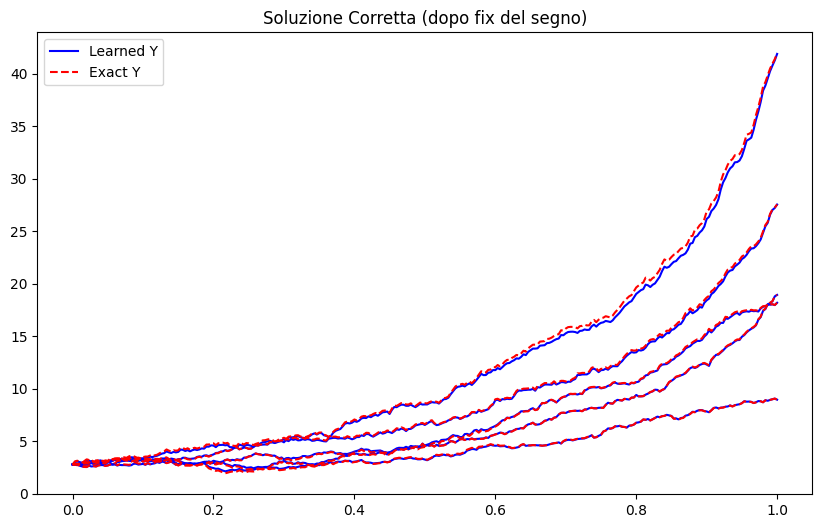

In [2]:
# implementazione classe NNImplemented
class NNImplemented(FBSNN):
    def __init__(self, Xi, T, M, N, D, layers, params):
        # Parametri definiti PRIMA di super().__init__
        self.mu = params['mu']
        self.a = params['a']
        self.b = params['b']
        self.c = params['c']
        self.sigma1 = params['sigma1']
        self.sigma2 = params['sigma2']
        self.sigma3 = params['sigma3']

        super().__init__(Xi, T, M, N, D, layers)

    def phi_tf(self, t, X, Y, Z):
        S, H, V, X_state = tf.split(X, num_or_size_splits=4, axis=1)
        
        # Casting
        mu = tf.cast(self.mu, tf.float32)
        c  = tf.cast(self.c, tf.float32)
        a  = tf.cast(self.a, tf.float32)
        b  = tf.cast(self.b, tf.float32)
        s3 = tf.cast(self.sigma3, tf.float32)

        exp_t = tf.exp(-t)
        
        # --- FIX SICUREZZA 1: Logaritmo protetto ---
        # Evita NaN se S diventa <= 0 per errore numerico
        safe_S = tf.maximum(S, 1e-6) 
        log_S = tf.log(safe_S)

        # Drift components
        term_S = mu * (c - log_S) * safe_S
        term_H = mu * (c - H)
        term_V = a * (X_state**2 + b*H + c*V)

        # (1 + H) per la matematica corretta di u=S+SH
        part1 = (1.0 + H) * term_S 
        part2 = term_H * safe_S # Usa safe_S anche qui
        part3 = (2.0*V + X_state) * term_V
        part4 = V**2 + s3**2

        equation = part1 + part2 + part3 + part4
        equation = tf.cast(equation, tf.float32)

        return -(Y - (exp_t * equation))

    def mu_tf(self, t, X, Y, Z):
        S, H, V, X_state = tf.split(X, num_or_size_splits=4, axis=1)
        
        mu = tf.cast(self.mu, tf.float32)
        c  = tf.cast(self.c, tf.float32)
        a  = tf.cast(self.a, tf.float32)
        b  = tf.cast(self.b, tf.float32)
        
        # --- FIX SICUREZZA 1 anche qui ---
        safe_S = tf.maximum(S, 1e-6)
        log_S = tf.log(safe_S)

        dS = mu * (c - log_S) * safe_S
        dH = mu * (c - H)
        dV = a * (X_state**2 + b*H + c*V)
        dX = V
        return tf.concat([dS, dH, dV, dX], axis=1)
    
    def g_tf(self, X):
        S, H, V, X_state = tf.split(X, num_or_size_splits=4, axis=1)
        exp_T = tf.exp(-self.T)
        val = S + (S*H) + (V**2) + (X_state*V)
        return exp_T * val

    def sigma_tf(self, t, X, Y):
        S, H, V, X_state = tf.split(X, num_or_size_splits=4, axis=1)
        
        # Casting parametri
        s1 = tf.cast(self.sigma1, tf.float32)
        s2 = tf.cast(self.sigma2, tf.float32)
        s3 = tf.cast(self.sigma3, tf.float32)

        zeros = tf.zeros_like(S)
        
        r1 = tf.concat([s1 * S, zeros, zeros, zeros], axis=1)
        r2 = tf.concat([zeros, s2 * tf.ones_like(H), zeros, zeros], axis=1)
        r3 = tf.concat([zeros, zeros, s3 * tf.ones_like(V), zeros], axis=1)
        r4 = tf.concat([zeros, zeros, zeros, zeros], axis=1)

        sigma_matrix = tf.stack([r1, r2, r3, r4], axis=1)
        return sigma_matrix

if __name__ == "__main__":
    import matplotlib.pyplot as plt

    # --- MODIFICA 1: Aumentiamo la precisione della simulazione ---
    M = 100      # Batch Size aumentato (era 100) -> Riduce il rumore del gradiente
    N = 300      # Step Temporali raddoppiati (era 50) -> Riduce l'errore di Eulero
    D = 4
    T = 1.0

    params = {
        'mu': np.float32(1.0),
        'c': np.float32(1.0),
        'b': np.float32(1.0),
        'a': np.float32(1.0),
        'sigma1': np.float32(0.5), # Volatilità basse aiutano
        'sigma2': np.float32(0.5),
        'sigma3': np.float32(0.5),
    }

    # Xi iniziale
    Xi = np.array([1.5, 0.5, 0.5, 0.5]).reshape(1, D)
    
    # Architettura (va bene così)
    layers = [D+1] + 4*[256] + [1]

    model = NNImplemented(Xi, T, M, N, D, layers, params)

    print('========Avvio del training High Precision========')
    
    # --- MODIFICA 2: Schedule più robusto ---
    # Fase di esplorazione veloce
    model.train(epochs=2000, learning_rate=1e-3)
    
    # Fase principale di convergenza (qui deve scendere sotto 1.0 di Loss)
    model.train(epochs=5000, learning_rate=1e-4) 
    
    # Fase di raffinamento (qui deve scendere sotto 0.1)
    model.train(epochs=5000, learning_rate=1e-5)
    
    # Fase finale di precisione
    model.train(epochs=5000, learning_rate=1e-6)
    
    # --- PLOTTING ---
    t_test, W_test = model.fetch_minibatch()
    X_pred, Y_pred = model.predict(Xi, t_test, W_test)
    
    def u_exact(t, Xi_arr):
        S = Xi_arr[:, 0:1]
        H = Xi_arr[:, 1:2]
        V = Xi_arr[:, 2:3]
        X = Xi_arr[:, 3:4]
        return np.exp(-t) * (S + S*H + V**2 + X*V)

    Xi_reshaped = X_pred.reshape(-1, D)
    t_reshaped = t_test.reshape(-1, 1)
    Y_exact = u_exact(t_reshaped, Xi_reshaped).reshape(M, N+1, 1)
    
    exact_Y0 = u_exact(np.array([[0.0]]), Xi)[0,0]
    print(f"\nPredicted Y0: {Y_pred[0,0,0]:.4f}")
    print(f"Exact Y0:     {exact_Y0:.4f}")
    
    plt.figure(figsize=(10,6))
    plt.plot(t_test[0,:,0], Y_pred[0,:,0], 'b', label='Learned Y')
    plt.plot(t_test[0,:,0], Y_exact[0,:,0], 'r--', label='Exact Y')
    plt.plot(t_test[1:5,:,0].T, Y_pred[1:5,:,0].T, 'b')
    plt.plot(t_test[1:5,:,0].T, Y_exact[1:5,:,0].T, 'r--')
    plt.title("Soluzione Corretta (dopo fix del segno)")
    plt.legend()
    plt.show()